# Chaos
> Differential equation can lead to chaos. What? How can that be? This post follows an examaple of the *equation of the logistic map*

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [simulation, differential equation, chaos]
- image: https://en.wikipedia.org/wiki/Logistic_map#/media/File:Logistic_Bifurcation_map_High_Resolution.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

This post is inspired by [The stunning beauty of Chaos theory](https://medium.com/@fabiograetz/the-stunning-beauty-of-chaos-theory-fd0e1597d68a).

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from ipywidgets import interactive
from IPython.core.display import HTML
from numba import jit
import numpy as np, pandas as pd, datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis

## equation of the logistic map
$$x_{i+1}=r \cdot x_{i}\left(1-x_{i}\right)$$
[More info about this equation](https://en.wikipedia.org/wiki/Logistic_map).

Here is an implementation of this itteration:

In [3]:
@jit(nopython=True)
def simulate(x_0, r, n=100, transients=100):
    
    x=x_0
    
    #Transients first
    for i in range(1,transients):
        x=r*x*(1-x)
    
    # Then "record" the rest
    xs = np.zeros(n)
    xs[0]=x
    for i in range(1,n):
        x=r*x*(1-x)
        xs[i]=x
        
    return xs

Here is an example simulation with the initial value $x_0=0.8$ and $r=1$:

In [4]:
#collapse
def simulate_and_plot(x_0=0.8, r=1, n=100, ax=None, **kwargs):
    
    xs = simulate(x_0=x_0, r=r, transients=0, n=n)
    
    if ax is None:
        fig,ax=plt.subplots()
    
    ax.plot(xs,'.-', **kwargs);
    ax.set_xlabel('itteration')
    ax.set_ylabel('x')
    ax.set_title('$x_0=%0.2f$, $r=%0.1f$' % (x_0,r))
    

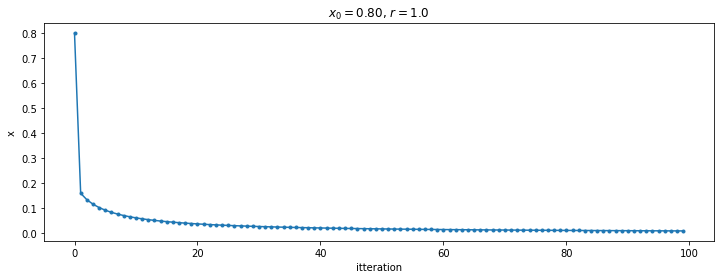

In [5]:
simulate_and_plot(x_0=0.8, r=1)

This equation is however extremely sensitive to changes in the intial condition. Even a very small difference in the intial value of $x_0$ can give a totally different behavious as is shown in this example:

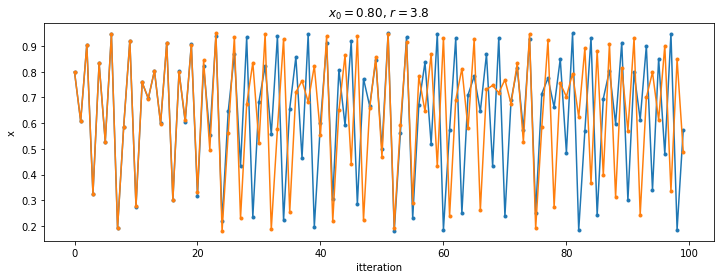

In [6]:
fig,ax=plt.subplots()
simulate_and_plot(x_0=0.8, r=3.8, n=100, ax=ax)
simulate_and_plot(x_0=0.800001, r=3.8, n=100, ax=ax)

## Bifurcation diagram
We want to make a *bifurcation diagram* showing how the solution changes for various initial values ($x_0$) and coefficients $r$. I will used the [datashader](https://datashader.org/) python package to visualize this. We will create a picture where each combination of $x_0$ and $r$ generates a series of $x$ values. All of these $x$ values are plotted against the $r$ value used.

If we would do this in a normal scatter plot, we would get points everywhere, which would not be a very informative graph. Instead datashader will make the points where there are a lot of points plotted ontop of each other darker, sp we can see that they are a more frequent combination or $x$ and $r$.

Here is an implementation running all of the simulations:
    

In [7]:
@jit(nopython=True)
def bifurcation_diagram(x0_s, r_s, n_i):
    """
    Create a bifurcation diagram for the logistic map equation
    
    Parameters
    -----------
    n_i : int
        number of itterations in simulation
    
    
    Return
    -----------
    data : ndarray
        [r,x,x0]
    
    """
    n_x = len(x0_s)
    n_r = len(r_s)
    
    n_rows = n_x*n_r*n_i
    data=np.zeros((n_rows,3))
    
    for i_r,r in enumerate(r_s):
        for i_x_0,x_0 in enumerate(x0_s):
            xs = simulate(x_0=x_0, r=r, n=n_i)
            row_start=i_r*n_r + i_x_0*n_x
            row_stop=row_start+n_i
            data[row_start:row_stop,0] = r*np.ones(n_i)
            data[row_start:row_stop,1] = xs
            data[row_start:row_stop,2] = x_0*np.ones(n_i)
            
    return data

Now generate a *bifurcation diagram*:

In [8]:
n_x=1000
n_r=10000
n_i=50 # number of itterations in simulation

x0_s = np.linspace(0.001,1,n_x)
r_s = np.linspace(2.95,4,n_r)

data = bifurcation_diagram(x0_s=x0_s, r_s=r_s, n_i=n_i)

We convert the results into a Pandas dataframe:

In [9]:
df = pd.DataFrame(data=data,columns=['r','x','x0'])
df.head()

,r,x,x0
0,2.95,0.661493,0.001
1,2.95,0.660564,0.001
2,2.95,0.661446,0.001
3,2.95,0.660609,0.001
4,2.95,0.661404,0.001


Now we can let the *datashader* do its magic to plot the data in the dataframe:

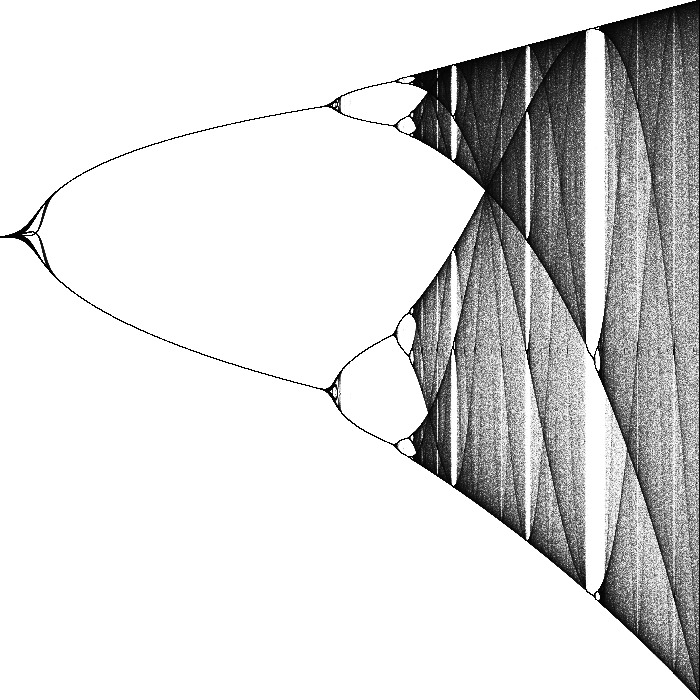

In [10]:
cvs = ds.Canvas(plot_width = 700, plot_height = 700, x_range=[r_s[0],r_s[-1]])
agg = cvs.points(df, 'r', 'x')

ds.transfer_functions.Image.border=0
tf.shade(agg, cmap = ["white", "black"])

So this is the solutions with intial values $x_0$ between 0 and 1 with $r$ between 2.95 and 4.